In [ ]:
! pip install gym
! git clone https://github.com/ClementRomac/gym-tictactoe
% cd gym-tictactoe
! python setup.py install

import time
import gym
import gym_tictactoe
import pickle
import collections
import random

In [ ]:
# Создает строку Q-таблицы для текущего состояния state, 
# Инициализируя все возможные action значениями по умолчанию Init_Q
def q_row(state, init_q: float):
    q = [0] * len(state)
    for i in range(len(state)):
        if (state[i] == 0):
            q[i] = init_q
        else: q[i] = -2   #Если клетка уже занята
    return q

# Определяет индекс максимального элемента массива
def argmax(array):
    max = array[0]
    index = 0
    for i in range(len(array)):
        if (array[i] > max):
            max = array[i]
            index = i
    return index

# Хеширует state
def get_hash(state):
    result = 0
    for k in range(len(state)):
        result += (state[k] + 1) * (3 ** k)
    return result

# Оценка наград после окончания эпизода
def update_reward(reward, user):
    if done: 
        if reward == 10:        # Ничья
            return 0

        elif reward == 20:
            if user == human: 
                return 1
            elif user != human: 
                return -1
    else: 
        return 0

In [ ]:
# Загрузка среды
env = gym.make('TicTacToe-v1', symbols=[-1, 1], board_size=3, win_size=3)

human = -1          # Обучающаяся сторона
loop = True         # Эпизоды разыгрываются, пока loop = True
alpha = 0.9         # Скорость обучения
gamma = 0.95        # Коэффициент дисконтирования
output = False      # Флаг, определяющий, будет ли происходить вывод в консоль
q_table = {}        # Q-таблица - словарь {Hash(state): Q(action)}

eps_greedy = 2      # Вероятность, с которой будет выбран случайный ход
n_greedy = 1000     # Число эпизодов для изменения eps_greedy на h_greedy
h_greedy = 0.1      # Шаг изменения вероятности
flag_greedy = False # Флаг, устанавливающийся при выборе eps-greedy. 
                    # (Нужно для более точного критерия останова)

n_stop = 1000       # Критерий останова 
                    # (Оптимальная политика не должна меняться n_stop раз)
n_stop_cur = 0      # Количество раз без изменений политики
episodes = 0        # Количество сыгранных эпизодов

In [ ]:
# Обучение
%%time
# Разыгрываются эпизоды
while (loop):
    user = -1       # Ходящий на данный момент игрок [-1: 'x', 1: 'o']

    # Переменная наблюдения observation. Сброс настроек среды перед началом игры
    if (user != human):
        temp_state = env.reset() 
        old_hash = None     # Переменная для хранения старого хеша (состояния)
    else:
        state = env.reset()
        old_hash = hash = get_hash(state)
        q_table[hash] = q_row(state, 0.1)

    done = False
    reward = 0          # Награда

    # Уменьшение eps_greedy каждые n_greedy эпизодов
    if (episodes % n_greedy == 0):
        eps_greedy -= h_greedy

    while not done:
        # Если ход не человека
        if (user != human):
            # Поиск случайной незанятой клетки
            cell = env.action_space.sample() 
            while (temp_state[cell] != 0):
                cell = env.action_space.sample()

            # Анализ позиции после совершения хода  
            state, reward, done, infos = env.step(cell, user)
            if (output): env.render()

            # Оценка наград
            reward = update_reward(reward, user)

            if not done:
                # Если текущего state нет в Q-таблице, то нужно его добавить
                hash = get_hash(state)
                if (hash not in q_table):
                    q_table[hash] = q_row(state, 0.1)

                if (old_hash != None):
                    y = reward + gamma * max(q_table[hash])
                    q_table[old_hash][action] = (1 - alpha) * q_table[old_hash][action] + alpha * y

                    if not flag_greedy:
                        if (max(q_table[old_hash]) == q_table[old_hash][action]):
                            n_stop_cur += 1
                        else: n_stop_cur = 0
                        if (n_stop_cur == n_stop):
                            loop = False
                old_hash = hash

        #Если ход человека 
        if (user == human):
            # Выбор хода по eps-greedy стратегии
            if (random.random() <= eps_greedy):
                action = env.action_space.sample() 
                while (state[action] != 0):
                    action = env.action_space.sample()
                flag_greedy = True
            else:
                action = argmax(q_table[hash])
                flag_greedy = False

            # Анализ позиции после совершения хода игроком
            # temp_state - состояние для среды
            temp_state, reward, done, infos = env.step(action, user)
            reward = update_reward(reward, user)
            if (output): env.render() 

        # Смена хода
        if (user == 1): user = -1 
        else: user = 1  

    # Обновление последнего хода
    q_table[hash][action] = reward

    if (output): print('===============')
    episodes += 1

# Сохранение q-таблицы в файл
with open('QLearn.pkl', 'wb') as f: 
    pickle.dump(q_table, f)
print('episodes =', episodes)

episodes = 21353
CPU times: user 11.3 s, sys: 164 ms, total: 11.5 s
Wall time: 15.6 s


In [ ]:
# Минимакс
import numpy as np
import pickle
from collections import deque

#Матрица выигрышей
win_matrix = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0],     # Горизонтали
                       [0, 0, 0, 1, 1, 1, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0, 1, 1, 1],
                       [1, 0, 0, 1, 0, 0, 1, 0, 0],     # Вертикали
                       [0, 1, 0, 0, 1, 0, 0, 1, 0],
                       [0, 0, 1, 0, 0, 1, 0, 0, 1],     
                       [1, 0, 0, 0, 1, 0, 0, 0, 1],     # Диагонали
                       [0, 0, 1, 0, 1, 0, 1, 0, 0]]).transpose()

# Возвращает строку, в которой найдена победа
def test_win(states, value):
    multiply = np.dot(states, win_matrix)
    i, j = np.where(multiply == value)
    return i
    
#Вывод state на экран
def print_state(state, symbols):
    print('|-----------|')
    for i in range(9):
        if ((i % 3 == 0) & (i > 0)):
            print('|\n|-----------|')
        if (state[i] == -1):
            print('|', symbols[0], end=' ')
        elif (state[i] == 1):
            print('|', symbols[1], end=' ')
        else:
            print('|  ', end=' ')
    print('|\n|-----------|')

# Хеширует state
def get_hash(state):
    result = 0
    for k in range(np.size(state)):
        result += (state[k] + 1) * (3 ** k)
    return result

# Создает q-строку, инициазизируя все нулем и учитывая занятые клетки (-2)
def state_to_q(state, is_busy):
    q_row = np.zeros(np.size(state))
    for i in range(np.size(state)):
        if (state[i] != 0):
            q_row[i] = is_busy # Клетка занята
        else:
            q_row[i] = 0
    return q_row

# Оценка. Ход наш
def mark(state, n_move):
    # Создание q-строки
    hash = get_hash(state)
    q[hash] = state_to_q(state, -2)

    # Очередь под действия
    actions = deque()

    #Матрица возможных состояний
    new_states = np.zeros((size - n_move, size))
    new_states[:] = np.copy(state)
    i = 0
    for j in range (size):
        if (state[j] == 0):
            new_states[i][j] = -1
            i += 1
            actions.append(j)

    # Поиск выигрышей
    index_win = test_win(new_states, -3)
    if (np.size(index_win)):
        for k in index_win:
            q[hash][actions[k]] = 1 #Победа
        return 1
    else:
        max = -1
        for k in range(len(new_states)):
            q[hash][actions[k]] = mark2(new_states[k], n_move + 1)
            if (q[hash][actions[k]] == 1):
                return 1
            if (q[hash][actions[k]] > max):
                max = q[hash][actions[k]]
        return max

# Оценка. Ход врага
def mark2(state, n_move):
    if (n_move == 9):   #Ничья
        return 0

    # Создание q-строки
    hash = get_hash(state)
    q[hash] = state_to_q(state, 2)

    # Очередь под действия
    actions = deque()

    #Матрица возможных состояний
    new_states = np.zeros((size - n_move, size))
    new_states[:] = np.copy(state)
    i = 0
    for j in range (size):
        if (state[j] == 0):
            new_states[i][j] = 1
            i += 1
            actions.append(j)

    # Поиск проигрышей
    index_win = test_win(new_states, 3)
    if (np.size(index_win)):
        for k in index_win:
            q[hash][actions[k]] = -1
        return -1 # Поражение
    else:
        min = 1
        for k in range(len(new_states)):
            q[hash][actions[k]] = mark(new_states[k], n_move + 1)
            if (q[hash][actions[k]] == -1):
                return -1
            if (q[hash][actions[k]] < min):
                min = q[hash][actions[k]]
        return min

size = 9                # Размер игрового поля
state = np.zeros(size)

user = -1
n_move = 0              # Количество поставленных фигур (Помогает ловить ничью)

q = {}

mark(state, 0)

# Сохранение q-таблицы в файл
with open('MinMax_2.pkl', 'wb') as f:
    pickle.dump(q, f)

In [ ]:
#Q-table VS MinMax

env = gym.make('TicTacToe-v1', symbols=[-1, 1], board_size=3, win_size=3)
human = -1           # Обучающаяся сторона
reward = 0          # Награда
episodes = 5000
output = False
output_result = False
min_max_wins = 0
q_learn_wins = 0

# Загрузка q-таблицы из файла
with open('QLearn.pkl', 'rb') as f: 
    q_table = pickle.load(f)

with open('MinMax_2.pkl', 'rb') as f: 
    min_max = pickle.load(f)

#Обученный ПК vs Человек
for i in range(episodes):
    state = env.reset() # Переменная наблюдения observation. Сброс настроек среды перед началом игры
    user = -1           # Ходящий на данный момент игрок [-1: 'x', 1: 'o']
    done = False

    while not done:
        # Ход MinMax
        if (user != human):   
            hash = get_hash(state)
            cell = random.choice((np.where(min_max[hash] == np.max(min_max[hash])))[0])
            if (output): env.render() 
        
        # Ход Q-table
        if (user == human):
            hash = get_hash(state)
            if (hash not in q_table):
                q_table[hash] = q_row(state, 0.6)
            cell = argmax(q_table[hash])
            if (output): env.render() 
        
        # Анализ позиции после совершения хода игроком  
        state, reward, done, infos = env.step(cell, user)       

        # Оценка наград после окончания эпизода
        if done:                                            
            if reward == 10:
                reward = 0.5
                if (output | output_result): print('Ничья')

            elif reward == 20:
                if user == human: 
                    if (output | output_result): print('QLearn выиграл')
                    q_learn_wins += 1
                elif user != human: 
                    if (output | output_result): print('MinMax выиграл')
                    min_max_wins += 1

        # Смена хода
        if (user == 1): user = -1 
        else: user = 1  

    # Вывод поля в консоль после окончания эпизода
    if (output | output_result): env.render()
    if (output | output_result): print('===============')

print('num_episodes = ', episodes)
print('minimax wins = ', min_max_wins)
print('q-learn wins = ', q_learn_wins)

num_episodes =  5000
minimax wins =  0
q-learn wins =  0


In [ ]:
# Игра с ообученным ПК
# Загрузка q-таблицы из файла
with open('QLearn.pkl', 'rb') as f: 
    q_table = pickle.load(f)

#Обученный ПК vs Человек
for i in range(5):
    state = env.reset() # Переменная наблюдения observation. Сброс настроек среды перед началом игры
    user = -1           # Ходящий на данный момент игрок [-1: 'x', 1: 'o']
    done = False

    while not done:
        # Если ходит человек
        if (user != human):   
            env.render() 
            print("Введите ваш ход (Строка, столбец):")
            row, col = map(int, input().split())    # Ввод строки и столбца
            cell = (row - 1) * int(len(state) ** 0.5) + col - 1 # Клетка, выбранная человеком
            while (state[cell] != 0):
                print("Клетка занята!")
                row, col = map(int, input().split())   # Ввод строки и столбца
                cell = (row - 1) * int(len(state) ** 0.5) + col - 1 # Клетка, выбранная человеком
        
        # Если ход ПК и текущего state нет в Q-таблице, то нужно его добавить
        if (user == human):
            hash = get_hash(state)
            if (hash not in q_table):
                q_table[hash] = q_row(state, 0.6)
            cell = argmax(q_table[hash])
            env.render() 
        
        # Анализ позиции после совершения хода игроком  
        state, reward, done, infos = env.step(cell, user)       

        # Оценка наград после окончания эпизода
        if done:                                            
            if reward == 10:
                print('Ничья')

            elif reward == 20:
                if user == human: 
                    print('Вы проиграли')
                elif user != human: 
                    print('Вы выиграли')

        # Смена хода
        if (user == 1): user = -1 
        else: user = 1  

    # Вывод поля в консоль после окончания эпизода
    env.render()
    print('===============')

# Сохранение q-таблицы в файл
with open('QLearn.pkl', 'wb') as f:
    pickle.dump(q_table, f)

In [ ]:
# Обучение, рассчитывающее в процессе процент побед каждые n партий

# Оценка наград после окончания эпизода
def update_reward(reward, user):
    if done: 
        if reward == 10:        # Ничья
            return 0

        elif reward == 20:
            if user == human:
                return 1

            elif user != human:
                return -1
    else: 
        return 0

cur_wins = 0          # Текущее количество побед
cur_loss = 0          # Текущее количество поражений
max_episodes = 30000  # Максимальное число эпизодов
percent_wins = {}     # Массив для хранения процента выигрышей каждые n_ep эпизодов
percent_loss = {}     # Массив для хранения процента проигрышей каждые n_ep эпизодов
n_ep = 1000
episodes = 0

# Разыгрываются эпизоды
while (episodes <= max_episodes):
    user = -1       # Ходящий на данный момент игрок [-1: 'x', 1: 'o']

    # Переменная наблюдения observation. Сброс настроек среды перед началом игры
    if (user != human):
        temp_state = env.reset() 
        old_hash = None     # Переменная для хранения старого хеша (состояния)
    else:
        state = env.reset()
        old_hash = hash = get_hash(state)
        q_table[hash] = q_row(state, -0.5)

    done = False
    reward = 0          # Награда

    # Уменьшение eps_greedy каждые n_greedy эпизодов
    if (episodes % n_greedy == 0):
        eps_greedy -= h_greedy

    if (episodes % n_ep == n_ep - 1):
        percent_wins[(int)(episodes / n_ep) + 1] = cur_wins / n_ep * 100
        percent_loss[(int)(episodes / n_ep) + 1] = cur_loss / n_ep * 100
        cur_wins = 0
        cur_loss = 0

    while not done:
        # Если ход не человека
        if (user != human):
            # Поиск случайной незанятой клетки
            cell = env.action_space.sample() 
            while (temp_state[cell] != 0):
                cell = env.action_space.sample()

            # Анализ позиции после совершения хода  
            state, reward, done, infos = env.step(cell, user)
            if (output): env.render()

            # Оценка наград
            reward = update_reward(reward, user)
            if (reward > 0): cur_wins += 1
            if (reward < 0): cur_loss += 1

            if not done:
                # Если текущего state нет в Q-таблице, то нужно его добавить
                hash = get_hash(state)
                if (hash not in q_table):
                    q_table[hash] = q_row(state, 0.1)

                if (old_hash != None):
                    y = reward + gamma * max(q_table[hash])
                    q_table[old_hash][action] = (1 - alpha) * q_table[old_hash][action] + alpha * y

                    if not flag_greedy:
                        if (max(q_table[old_hash]) == q_table[old_hash][action]):
                            n_stop_cur += 1
                        else: n_stop_cur = 0
                        if (n_stop_cur == n_stop):
                            loop = False
                old_hash = hash

        #Если ход человека 
        if (user == human):
            # Выбор хода по eps-greedy стратегии
            if (random.random() <= eps_greedy):
                action = env.action_space.sample() 
                while (state[action] != 0):
                    action = env.action_space.sample()
                flag_greedy = True
            else:
                action = argmax(q_table[hash])
                flag_greedy = False

            # Анализ позиции после совершения хода игроком
            # temp_state - состояние для среды
            temp_state, reward, done, infos = env.step(action, user)
            reward = update_reward(reward, user)
            if (reward > 0): cur_wins += 1
            if (reward < 0): cur_loss += 1
            if (output): env.render() 

        # Смена хода
        if (user == 1): user = -1 
        else: user = 1  

    # Обновление последнего хода
    q_table[hash][action] = reward

    if (output): print('===============')
    episodes += 1

# Сохранение q-таблицы в файл
with open('QLearn.pkl', 'wb') as f: 
    pickle.dump(q_table, f)

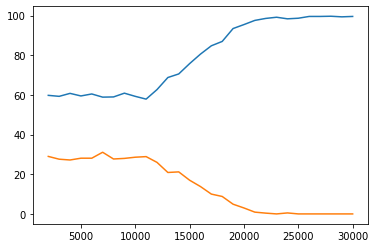

In [ ]:
# Построение графиков
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'Число эпизодов': pd.Series(list(percent_wins.keys())) * n_ep, 'Число проигрышей': percent_loss, 'Число выигрышей': percent_wins}) 
plt.plot(df['Число эпизодов'], df['Число выигрышей'])
plt.plot(df['Число эпизодов'], df['Число проигрышей'])

In [ ]:
# Игра против минимакса

# Определяет индекс минимального элемента массива
def argmin(array):
    min = 2
    index = 0
    for i in range(len(array)):
        if (array[i] != -2) & (array[i] < min):
            min = array[i]
            index = i
    return index


# Загрузка q-таблицы из файла
human = -1

with open('MinMax_2.pkl', 'rb') as f: 
    q_table = pickle.load(f)

#Обученный ПК vs Человек
for i in range(5):
    state = env.reset() # Переменная наблюдения observation. Сброс настроек среды перед началом игры
    user = -1           # Ходящий на данный момент игрок [-1: 'x', 1: 'o']
    done = False

    while not done:
        # Если ходит человек
        if (user == human):   
            env.render() 
            print("Введите ваш ход (Строка, столбец):")
            row, col = map(int, input().split())    # Ввод строки и столбца
            cell = (row - 1) * int(len(state) ** 0.5) + col - 1 # Клетка, выбранная человеком
            while (state[cell] != 0):
                print("Клетка занята!")
                row, col = map(int, input().split())   # Ввод строки и столбца
                cell = (row - 1) * int(len(state) ** 0.5) + col - 1 # Клетка, выбранная человеком
        
        # Если ход ПК (minmax)
        if (user != human):
            hash = get_hash(state)
            if (human ==  1): cell = argmax(q_table[hash])
            if (human == -1): cell = argmin(q_table[hash])
            print(cell)
            env.render() 
        
        # Анализ позиции после совершения хода игроком  
        state, reward, done, infos = env.step(cell, user)       

        # Оценка наград после окончания эпизода
        if done:                                            
            if reward == 10:
                print('Ничья')

            elif reward == 20:
                if user == human: 
                    print('Вы проиграли')
                elif user != human: 
                    print('Вы выиграли')

        # Смена хода
        if (user == 1): user = -1 
        else: user = 1  

    # Вывод поля в консоль после окончания эпизода
    env.render()
    print('===============')